# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [2]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
#np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)

<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [3]:
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.corpus import stopwords

#nltk.download("stopwords")
stop = stopwords.words('english')
porter = PorterStemmer()
#1043
del stop[116]
del stop[116]
del stop[116]
#print(stop)
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)|!', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

Let's give it at try:

In [4]:
tokenizer('This :) is a <a> test! :-)</br> no')

['test', 'no', ':)', '!', ':)']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [5]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [6]:
next(stream_docs(path='shuffled_movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

# Excercise 1: define new features according to https://web.stanford.edu/~jurafsky/slp3/5.pdf

# Obtener Nuevas Caracteristicas - Ejercicio 1

Cargamos palabras negativas del csv

In [9]:
negative = pd.read_csv("opinion-lexicon-English/negative-words.csv")
print(negative.head(4))

         word
0    abnormal
1     abolish
2  abominable
3  abominably


Cargamos palabras positivas del csv

In [10]:
positive = pd.read_csv("opinion-lexicon-English/positive-words.csv")
print(positive.head(4))

        word
0         a+
1     abound
2    abounds
3  abundance


Limpiamos los datos para evitar errores en las iteraciones, y para evitar tags html

In [11]:
#clean data

df['review'] = df['review'].str.replace('I\'', 'i ')
df['review'] = df['review'].str.replace('<br />', ' ')

negative['word'][467] = 'bull'
negative['word'][1559] = 'fuck'


En esta parte toma aproximadamente 9 min en generar todas las caracteristicas, por esta razon se guardo con anterioridad en data_movie.csv.

In [12]:
if False:
    df['x1'] = 0
    df['x2'] = 0

    for i in range(len(positive)):
        counter = df['review'].str.count(positive['word'][i])
        df['x1'] = counter + df['x1']

    for i in range(len(negative)):
        counter = df['review'].str.count(negative['word'][i])
        df['x2'] = counter + df['x2']

    df['x3'] = df['review'].str.contains('no', case=False).astype(int)
    df['x4'] = df['review'].str.count('i ') + \
        df['review'].str.count('I ')   + \
        df['review'].str.count('I\'')  + \
        df['review'].str.count('i\'')  + \
        df['review'].str.count('you ') + \
        df['review'].str.count('You ') + \
        df['review'].str.count(' u ')  + \
        df['review'].str.count(' U ')  + \
        df['review'].str.count(' u\'')

    df['x5'] = df['review'].str.contains('!', case=False).astype(int)
    df['x6'] = np.log(df['review'].str.count(' ').add(1))
else:
    df = pd.read_csv('data_movie.csv')

print(df.head())

                                              review  sentiment   x1  x2  x3  \
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1   90  30   1   
1  OK... so... I really like Kris Kristofferson a...          0   82  41   1   
2  ***SPOILER*** Do not read this, if you think a...          0  108  47   1   
3  hi for all the people who have seen this wonde...          1   31   7   0   
4  I recently bought the DVD, forgetting just how...          0   39  25   0   

   x4  x5        x6  
0   0   0  5.472271  
1   8   1  5.459586  
2   6   1  5.673323  
3   7   0  4.394449  
4   3   0  4.770685  


# Analisis de Datos

In [13]:
# Para la visualización de matriz
import matplotlib.pyplot as plt

# Para visualizacion estadistica
import seaborn as sns
sns.set(color_codes=True)

from scipy import stats
from scipy.stats import skew 

Genereción de datos

In [14]:
X = df.copy()
X.drop('review', 1, inplace=True)
X.drop('sentiment', 1, inplace=True)
print(X.describe())

                 x1            x2            x3            x4            x5  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      95.824780     33.218180      0.887120      4.959300      0.346980   
std       73.100208     27.148119      0.316449      4.600916      0.476014   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       50.000000     16.000000      1.000000      2.000000      0.000000   
50%       72.000000     25.000000      1.000000      4.000000      0.000000   
75%      117.000000     41.000000      1.000000      7.000000      1.000000   
max      947.000000    412.000000      1.000000     67.000000      1.000000   

                 x6  
count  50000.000000  
mean       5.230838  
std        0.644208  
min        1.386294  
25%        4.844187  
50%        5.153292  
75%        5.638355  
max        7.811973  


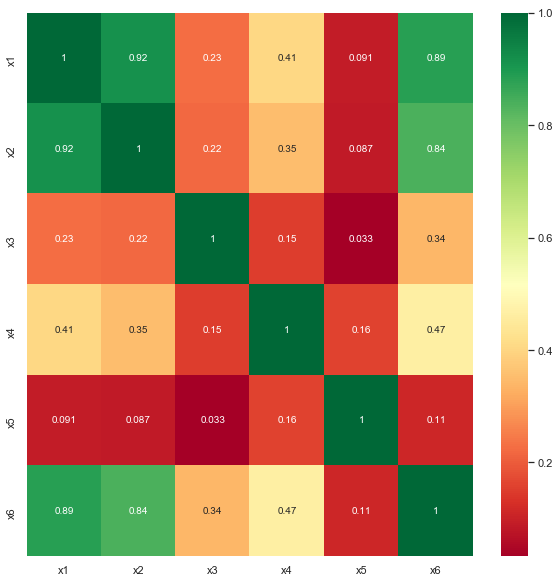

In [15]:
corrmat = X.corr()

plt.figure(figsize=(10,10))
g = sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


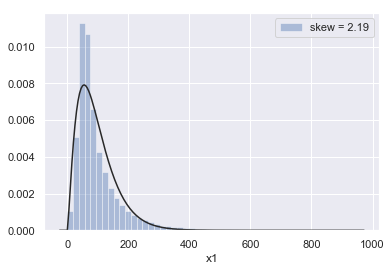

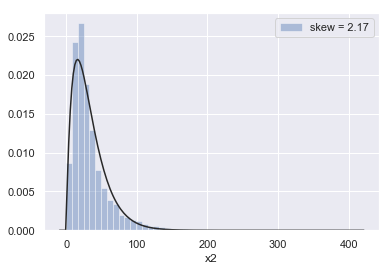

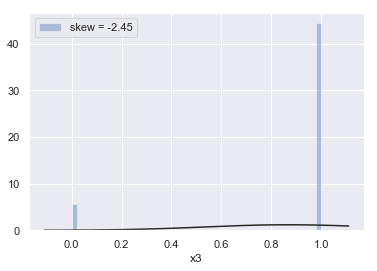

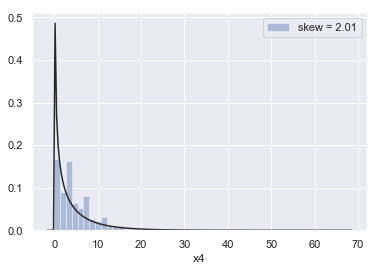

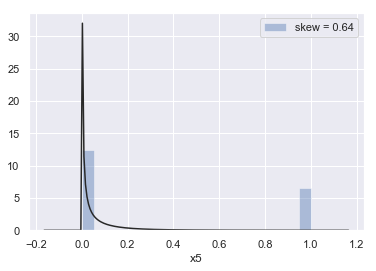

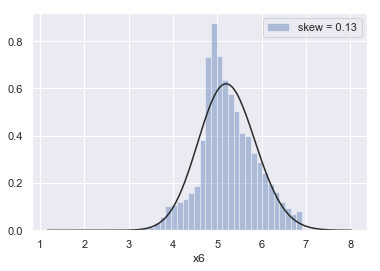

In [16]:
skews = X.skew()

for col in X.columns.tolist():
    if (X[col].dtype == 'float64') or (X[col].dtype == 'int64') :
        sns.distplot(X[col].dropna(), kde=False, label="skew = " + str(round(skews[col],2)), fit=stats.gamma)
        plt.legend()
        plt.show()
        
del skews 

<Figure size 864x720 with 0 Axes>

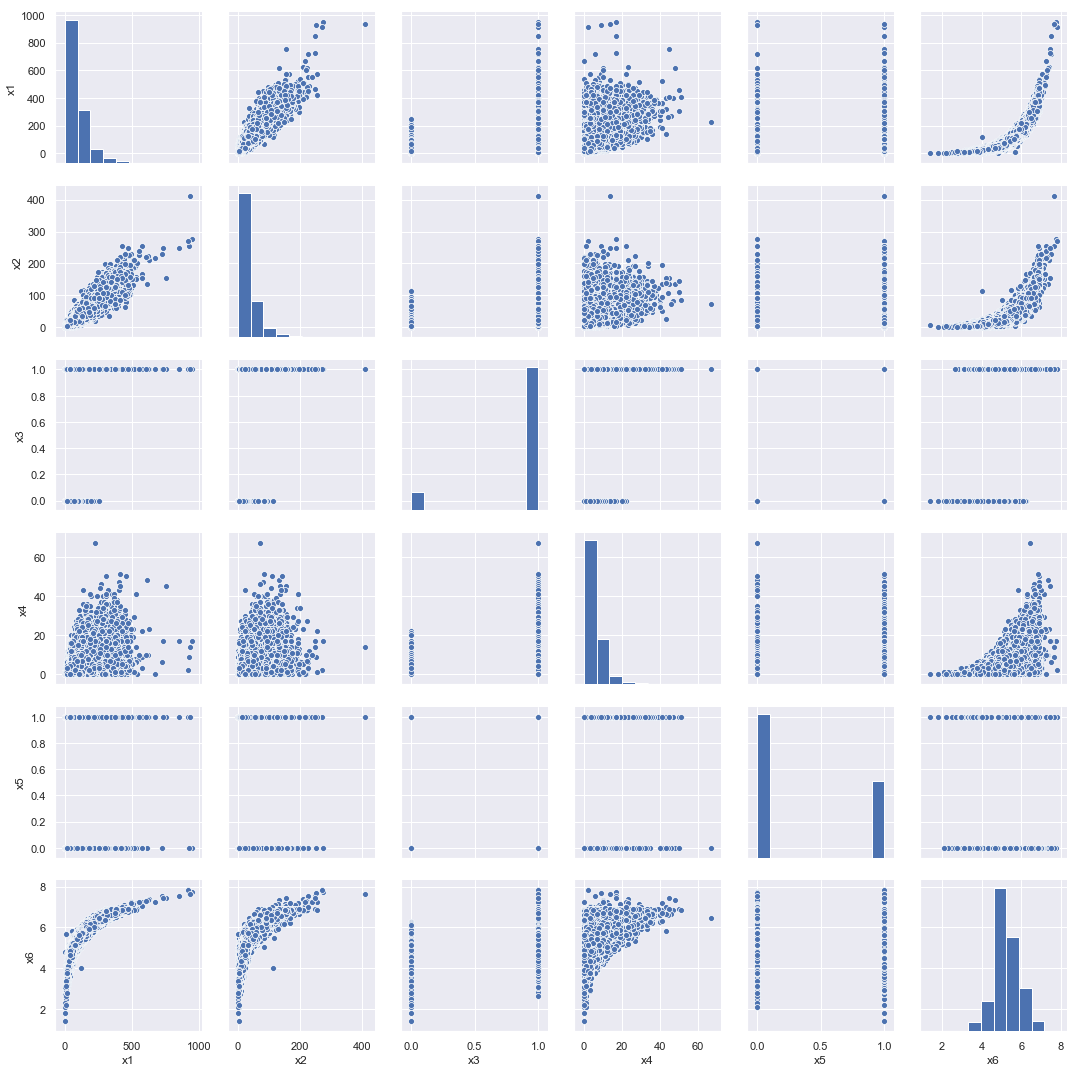

In [17]:
plt.figure(figsize=(12,10))
sns.pairplot(X, dropna=True)
plt.show()

x1    1.000000
x2    0.916593
x6    0.886567
x4    0.405796
x3    0.227722
x5    0.091041
Name: x1, dtype: float64


<Figure size 1008x504 with 0 Axes>

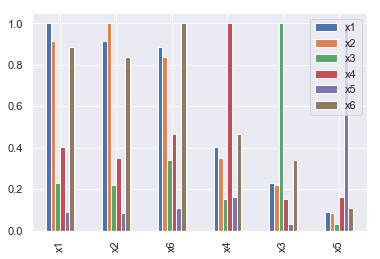

In [18]:
corr = X.corr()
print(corr.sort_values("x1", ascending = False).x1)
corr = corr.sort_values("x1", ascending = False)
plt.figure(figsize=(14,7))
corr.plot.bar()
plt.show()

# Regresión Logistica con Regularización - Ejercicio 2

In [19]:
# import

from sklearn.model_selection import train_test_split


Modificamos los dataSet para poder usar Numpy y sus propiedades.

In [20]:
y = df['sentiment']
y = df.copy()
y.drop('review', 1, inplace=True)
y.drop('x1', 1, inplace=True)
y.drop('x2', 1, inplace=True)
y.drop('x3', 1, inplace=True)
y.drop('x4', 1, inplace=True)
y.drop('x5', 1, inplace=True)
y.drop('x6', 1, inplace=True)
y = y.values

X = df.copy()
X.drop('review', 1, inplace=True)
X.drop('sentiment', 1, inplace=True)
X = X.values

Definimos las constantes de iteracion del algoritmo de Gradiente Decendiente

In [21]:
lr =0.01
n_iter = 200000
regularization_rate = 0.0000000001
theta = np.random.randn(7,1)
X_b = np.c_[np.ones((len(X),1)),X]

Separamos el DataSet para la Validación

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X_b,y,test_size=0.2,random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 7)
(10000, 7)
(40000, 1)
(10000, 1)


Se define el algoritmo de gradiente decendiente donde tenemos las siguiente variables, retorna el accuracy del ultimo set Theta

X = data de entrenamiento

Y = valor a entrenar

theta = arreglo de valores theta

iterations = cantidad de veces que se ejecutara el algoritmo

regularization_rate = el lambda q se usara en la regularizacion

In [23]:
def gradient_descent(X, y, theta, learning_rate=0.01, iterations=100, regularization_rate=0.1):
    accuracy = 0
    for i in range(iterations):
        F = np.matmul(theta.T,np.transpose(X))
        prediction = (1.0/(1.0 + np.exp(-F)))
        temp_theta = np.matmul(np.transpose(y) - prediction, X)
        theta += (regularization_rate * temp_theta).T
    accuracy = (40000-np.sum(np.absolute(np.transpose(y)-prediction)))/40000
    return accuracy

Al ejecutar el algoritmos obtenemos un accuracy de 58% en el conjunto de , para 200000 iteraciones

In [24]:

train_accuracy = gradient_descent(X_train, y_train, theta, lr, n_iter, regularization_rate)
print("Accuracity Train: " + str(train_accuracy))

Accuracity Train: 0.5807259068565874


Al ejecutar en la data de Test obtenemos 57%.

In [25]:
F = np.matmul(theta.T,np.transpose(X_test))
prediction_test = (1.0 / (1.0 + np.exp(-np.matmul(theta.T,np.transpose(X_test)))))
accuracity_test = (10000 - np.sum(np.absolute(np.transpose(y_test)-prediction_test))) / 10000
print("Accuracity Test: " + str(accuracity_test))

Accuracity Test: 0.5703395345126984


In [26]:
print('Theta 0: {:0.3f}\nTheta 1: {:0.3f}\nTheta 2: {:0.3f}\nTheta 3: {:0.3f}\nTheta 4: {:0.3f}\nTheta 5: {:0.3f}\nTheta 6: {:0.3f}'.format(theta[0][0], theta[1][0], theta[2][0], theta[3][0], theta[4][0], theta[5][0], theta[6][0]))

Theta 0: -1.037
Theta 1: 0.233
Theta 2: -0.333
Theta 3: 0.547
Theta 4: -0.428
Theta 5: 0.233
Theta 6: -1.932


# Regeción Logistica con libreria

In [27]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
doc_stream = stream_docs(path='shuffled_movie_data.csv')
# Excercise 2: implement a Logistic Regression classifier, using regularization, according to https://web.stanford.edu/~jurafsky/slp3/5.pdf

In [28]:
#import pyprind
#pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    #pbar.update()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: 

Depending on your machine, it will take about 2-3 minutes to stream the documents and learn the weights for the logistic regression model to classify "new" movie reviews. Executing the preceding code, we used the first 45,000 movie reviews to train the classifier, which means that we have 5,000 reviews left for testing:

In [29]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.869


I think that the predictive performance, an accuracy of ~87%, is quite "reasonable" given that we "only" used the default parameters and didn't do any hyperparameter optimization. 

After we estimated the model perfomance, let us use those last 5,000 test samples to update our model.

In [30]:
clf = clf.partial_fit(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


<br>
<br>

# Model Persistence

In the previous section, we successfully trained a model to predict the sentiment of a movie review. Unfortunately, if we'd close this IPython notebook at this point, we'd have to go through the whole learning process again and again if we'd want to make a prediction on "new data."

So, to reuse this model, we could use the [`pickle`](https://docs.python.org/3.5/library/pickle.html) module to "serialize a Python object structure". Or even better, we could use the [`joblib`](https://pypi.python.org/pypi/joblib) library, which handles large NumPy arrays more efficiently.

To install:
conda install -c anaconda joblib

In [33]:
import joblib
import os
if not os.path.exists('./pkl_objects'):
    os.mkdir('./pkl_objects')
    
joblib.dump(vect, './vectorizer.pkl')
joblib.dump(clf, './clf.pkl')

['./clf.pkl']

Using the code above, we "pickled" the `HashingVectorizer` and the `SGDClassifier` so that we can re-use those objects later. However, `pickle` and `joblib` have a known issue with `pickling` objects or functions from a `__main__` block and we'd get an `AttributeError: Can't get attribute [x] on <module '__main__'>` if we'd unpickle it later. Thus, to pickle the `tokenizer` function, we can write it to a file and import it to get the `namespace` "right".

In [34]:
%%writefile tokenizer.py
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

Writing tokenizer.py


In [35]:
from tokenizer import tokenizer
joblib.dump(tokenizer, './tokenizer.pkl')

['./tokenizer.pkl']

Now, let us restart this IPython notebook and check if the we can load our serialized objects:

In [36]:
import joblib
tokenizer = joblib.load('./tokenizer.pkl')
vect = joblib.load('./vectorizer.pkl')
clf = joblib.load('./clf.pkl')

After loading the `tokenizer`, `HashingVectorizer`, and the tranined logistic regression model, we can use it to make predictions on new data, which can be useful, for example, if we'd want to embed our classifier into a web application -- a topic for another IPython notebook.

In [37]:
example = ['I did not like this movie']
X = vect.transform(example)
clf.predict(X)

array([0])

In [38]:
example = ['I loved this movie']
X = vect.transform(example)
clf.predict(X)

array([1])